# Plot basic classification event selecttion cuts

last edit Mar-20, 2023

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

In [3]:
figures_path = "/Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/"
import ROOT 

Welcome to JupyROOT 6.26/04


# (1) Load data and cut values

In [5]:
cuts = pd.read_csv( '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/cuts/BANDcutValues.csv' );

## (1.1) Load data

In [6]:
pipsfilename = '/Users/erezcohen/Desktop/data/BAND/inclusive_no_cuts/skimmed_SIDIS_sidisdvcs_006421_e_piplus.root'
pimsfilename = '/Users/erezcohen/Desktop/data/BAND/inclusive_no_cuts/skimmed_SIDIS_sidisdvcs_006421_e_piminus.root'

In [22]:
NeventsMax = 1000# 0 #00

In [27]:
Nevntries = NeventsMax
e_Sector, pi_Sector = dict(),dict()
Ve_z,     Vpi_z     = dict(),dict()
W,Q2,y              = dict(),dict(),dict()
e_P,pi_P,e_Theta,pi_Theta,e_Phi,pi_Phi            = dict(),dict(),dict(),dict(),dict(),dict()
e_E_PCAL, e_E_ECIN, e_E_ECOUT, e_PCAL_W, e_PCAL_V = dict(),dict(),dict(),dict(),dict()
Zpi = dict()


Ve = ROOT.TVector3()
Vpi = ROOT.TVector3()

e = ROOT.TLorentzVector()
pi = ROOT.TLorentzVector()


for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    
    filename = '~/Desktop/data/BAND/inclusive_no_cuts/skimmed_SIDIS_sidisdvcs_006421_e_%s.root'%pi_ch
    f = ROOT.TFile(filename)
    tree = f.Get("tree")
    
    W[pi_ch],Q2[pi_ch],y[pi_ch]      = [],[],[]
    e_P[pi_ch],     pi_P[pi_ch]      = [],[]
    e_Theta[pi_ch], pi_Theta[pi_ch]  = [],[]  
    e_Phi[pi_ch],   pi_Phi[pi_ch]    = [],[]
    e_Sector[pi_ch],pi_Sector[pi_ch] = [],[]    
    Ve_z[pi_ch],    Vpi_z[pi_ch]     = [],[]
    e_E_PCAL[pi_ch], e_E_ECIN[pi_ch], e_E_ECOUT[pi_ch], e_PCAL_W[pi_ch], e_PCAL_V[pi_ch] = [],[],[],[],[]
    
    Zpi[pi_ch] = []

    
    for entryNum in range(0,np.min([Nevntries,tree.GetEntries()])):
        tree.GetEntry(entryNum)
        
        e_E_PCAL[pi_ch] .append( getattr(tree,"e_E_PCAL") ) 
        e_E_ECIN[pi_ch] .append( getattr(tree,"e_E_ECIN") )
        e_E_ECOUT[pi_ch].append( getattr(tree,"e_E_ECOUT") )
        e_PCAL_W[pi_ch] .append( getattr(tree,"e_PCAL_W") )
        e_PCAL_V[pi_ch] .append( getattr(tree,"e_PCAL_V") )
        e_Sector[pi_ch] .append(getattr(tree,"e_DC_sector") )

        
        e = getattr(tree,"e") 
        Ve =  getattr(tree,"Ve") 

        Ve_z[pi_ch]    .append(Ve.Z()) 
        e_P[pi_ch]     .append(e.P()) 
        e_Theta[pi_ch] .append(e.Theta()) 
        e_Phi[pi_ch]   .append(e.Phi()) 


        y[pi_ch]       .append(getattr(tree,"y"))
        W[pi_ch]       .append(getattr(tree,"W"))
        Q2[pi_ch]      .append(getattr(tree,"Q2"))

        
        Npi = getattr(tree,"Npi")
        if Npi>0:
            pi =  getattr(tree,"pi") 
            Vpi =  getattr(tree,"Vpi") 
            pi_DC_sector = getattr(tree,"pi_DC_sector")
            Zpi[pi_ch]      .append( getattr(tree,"Z") )
            pi_P[pi_ch]     .append(pi[0].P()) 
            pi_Theta[pi_ch] .append(pi[0].Theta()) 
            pi_Phi[pi_ch]   .append(pi[0].Phi()) 
            pi_Sector[pi_ch].append(pi_DC_sector[0]) 
            Vpi_z[pi_ch]    .append(Vpi[0].Z()) 
        else:
            Zpi[pi_ch]      .append( -1000 )
            pi_P[pi_ch]     .append( -1000 ) 
            pi_Theta[pi_ch] .append( -1000 ) 
            pi_Sector[pi_ch].append( -1000 ) 
            Vpi_z[pi_ch]    .append( -1000 )
    f.Close()
print('done')

done


In [ ]:
def compute_cut_impact_on_statistics(Npips,Npims,Npips_noCuts=1,Npims_noCuts=1):
    Npips,Npims = len(Events['piplus']),len(Events['piminus'])
    
    fpips  = 100.*Npips/Npips_noCuts
    dfpips = fpips * np.sqrt(1./np.max(Npips,1)+1./Npips_noCuts)
    fpims  = 100.*Npims/Npims_noCuts
    dfpims = fpims * np.sqrt(1./np.max(Npims,1)+1./Npims_noCuts)

    return Npips,Npims,fpips,dfpips,fpims,dfpims 

In [29]:
Events = dict()
Nevents = pd.DataFrame(Names={'Cut order','Cut','$N_{\pi^+}$','$N_{\pi^-}$',
                              '$f_{\pi^+}$ [%]','$\Delta f_{\pi^+}$ [%]',
                              '$f_{\pi^-}$ [%]','$\Delta f_{\pi^-}$ [%]'})
for pi_ch in pi_charge_names:
    Events[pi_ch] = pd.DataFrame({'e_E_PCAL' :e_E_PCAL[pi_ch],
                                  'e_E_ECIN' :e_E_ECIN[pi_ch],                                
                                  'e_E_ECOUT':e_E_ECOUT[pi_ch],
                                  'e_PCAL_W' :e_PCAL_W[pi_ch],
                                  'e_PCAL_V' :e_PCAL_V[pi_ch],
                                  
                                  'Ve_z'     :Ve_z[pi_ch],
                                  'e_P'      :e_P[pi_ch],
                                  'e_Theta'  :e_Theta[pi_ch],
                                  'e_Phi'    :e_Theta[pi_ch],
                                  'e_Sector' :e_Sector[pi_ch],
                                  'y'        :y[pi_ch],
                                  'W'        :W[pi_ch],
                                  'Q2'       :Q2[pi_ch],

                                  'Vpi_z'    :Vpi_z[pi_ch],
                                  'pi_P'     :pi_P[pi_ch],
                                  'pi_Theta' :pi_Theta[pi_ch],
                                  'pi_Phi'   :pi_Theta[pi_ch],
                                  'pi_Sector':pi_Sector[pi_ch],   
                                  'Zpi'      :Zpi[pi_ch],
                                 })
print('Created dataFrames')
Npips,Npims = len(Events['piplus']),len(Events['piminus'])
fpips  = 100.*Npips/len(Events['piplus'])
dfpips = fpips * np.sqrt(1./Npips+1./len(Events['piplus']))
fpims  = 100.*Npims/len(Events['piminus'])
dfpims = fpims * np.sqrt(1./Npips+1./len(Events['piminus']))
Nevents.append(pd.DataFrame({0,'No cut',Npips,Npims,fpips,dfpips,fpims,dfpims}))
Nevents

created dataFrames


# (2) plot relevant variables
For each plot, we try to repeat twice: before and after all previous cuts

The order of cuts is as listed in the analysis note:
1. PCAL fiducial cuts $V_{PCAL} > 19 $ cm and $W_{PCAL} > 19 $ cm 
        
2. PCAL minimum energy deposition cut $PCAL_{dep} > 70$ MeV

3. Calorimetry sampling fraction cut  $\Delta E_{dep}(PCAL + ECIN + ECOUT) / p_e > 0.17$ 

4. $ \frac{E_{ECIN}}{p} > 0.2 - \frac{E_{PCAL}}{p}$ 

5. Vertex $z$ position $-13.0 \mathrm{cm} < v_z < + 12.0 \mathrm{cm}$ 

6. Difference between vertex $z$-position of the electron and the pion $|v_z(e) - v_z(\pi)| < 20.0$ cm 

7. Cut on $\chi^2_{PID}$ from the Event Builder for the pions 

8. DC fiducial cuts 

9. Enhance DIS contribution $W > 2.5$ GeV/c$^2$  

10. Enhance DIS contribution $Q > 2$ (GeV/c)$^2$

11. Suppress QE contribution $y < 0.75$  

12. Reduce the contamination from exclusive processes $M_x > 1.7$ GeV/c$^2$

13. Electron momentum $3 < p_e < 10$ GeV/c  

14. Suppress Kaon contamination in the pion sample $1.25 < p_\pi < 5$ GeV/c  

15. Focus on high acceptance the HTCC $5^\circ < \theta_e < 35^\circ$ and $5^\circ < \theta_\pi < 35^\circ$  

16. Leading outgoing pions $z_\pi>0.3$ 

17. $\pi^+$ and $\pi^-$ acceptance matching cut 


### 1. PCAL V and W

In [ ]:
Vmin = float(cuts[cuts.parameter=='e_PCAL_V_min'].value)
Wmin = float(cuts[cuts.parameter=='e_PCAL_V_min'].value)
for pi_ch in pi_charge_names:
    Events[pi_ch+'After cut 1'] = Events[pi_ch][ (Vmin < Events[pi_ch].e_PCAL_V) 
                                                &(Wmin < Events[pi_ch].e_PCAL_W) ]
    Nevents[pi_ch+'After cut 1']
    print()

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_PCAL_W_and_e_PCAL_V.pdf


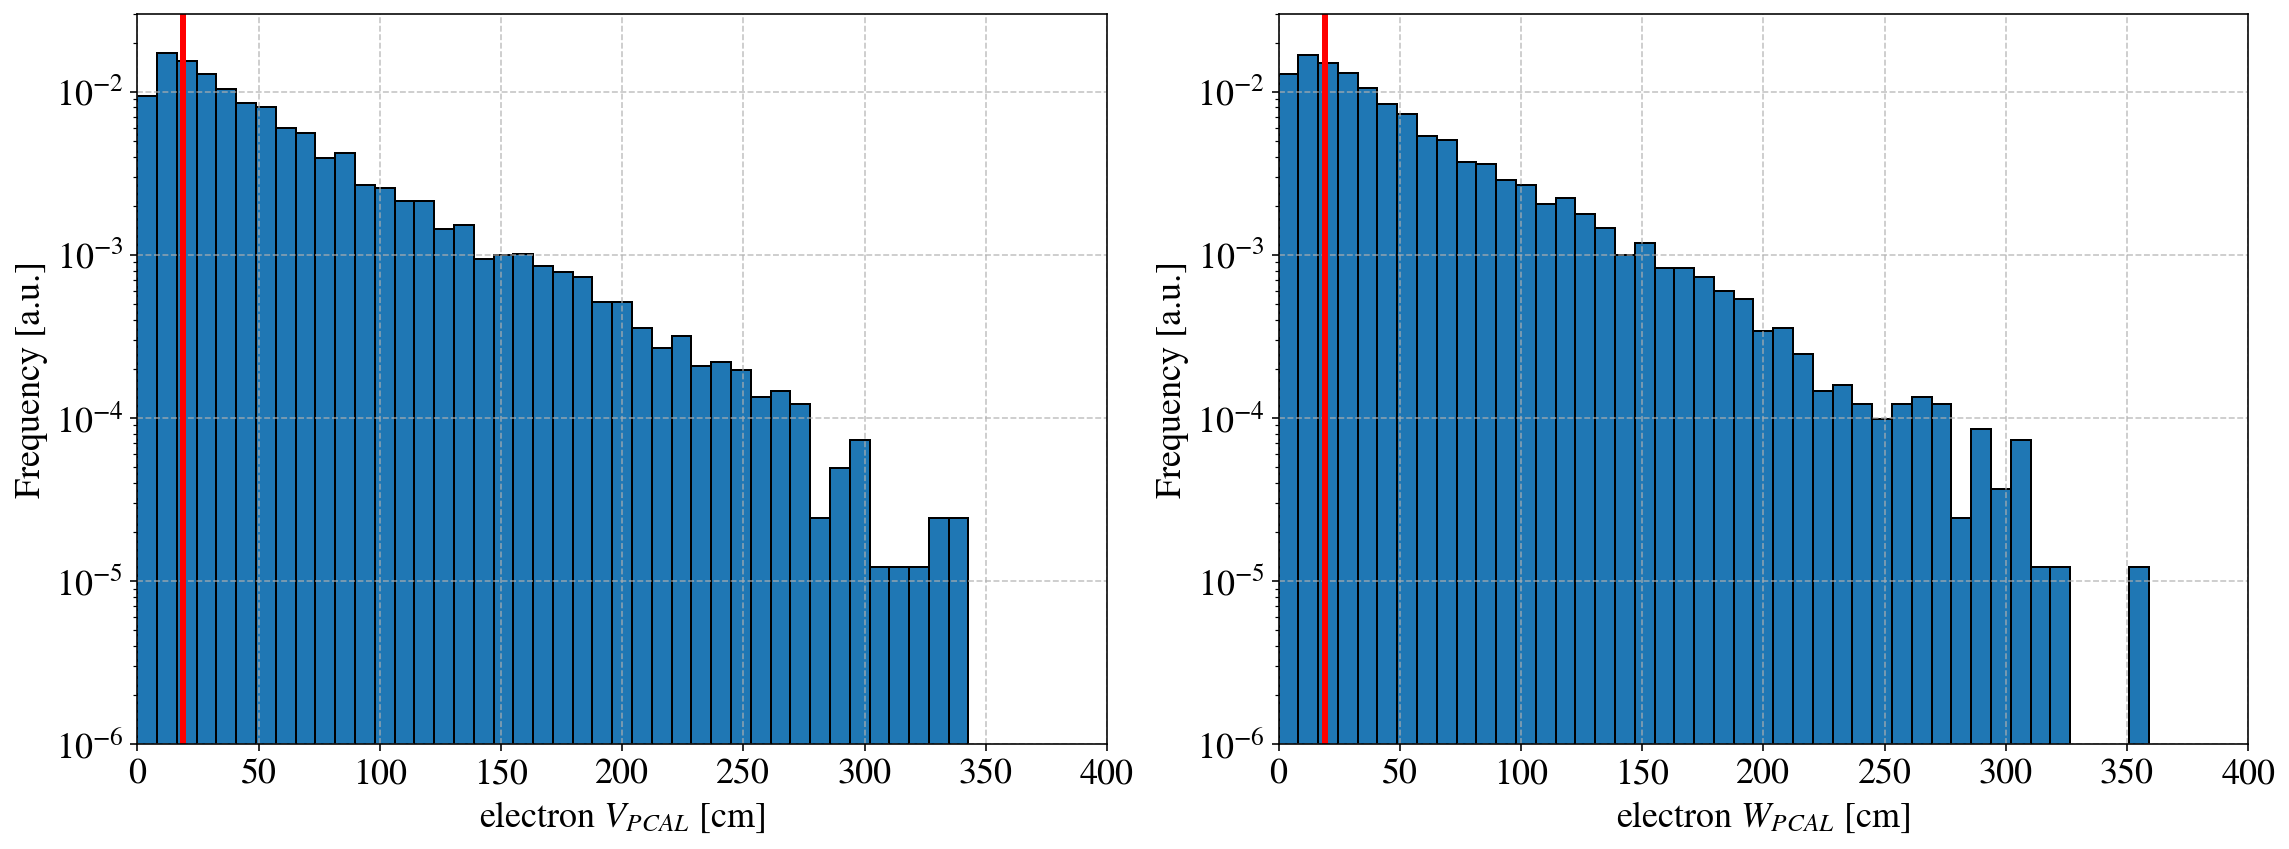

In [18]:
pi_ch = 'piplus'
xmin,xmax,ymin,ymax,Nbins = 0,400,0,400,50
x = np.array(e_PCAL_V[pi_ch])
y = np.array(e_PCAL_W[pi_ch])
fig = plt.figure(figsize=(16,6),tight_layout=True)
ax = fig.add_subplot(1,2,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'electron $V_{PCAL}$ [cm]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-6,3e-2),do_add_grid=True)
ax.set_yscale('log')
plt.plot([Vmin,Vmin],[1e-7,1e-1],'-r',linewidth=3);

ax = fig.add_subplot(1,2,2)
plt.hist( y, bins=np.linspace(ymin,ymax,Nbins),density=True,edgecolor='k');
set_axes(ax,'electron $W_{PCAL}$ [cm]','Frequency [a.u.]',fontsize=18, xlim=(ymin,ymax),ylim=(1e-6,3e-2),do_add_grid=True)
ax.set_yscale('log')
plt.plot([Wmin,Wmin],[1e-7,1e-1],'-r',linewidth=3);

# save_figure(filename = figures_path + 'e_PCAL_W_and_e_PCAL_V' + '.pdf')
save_figure(filename = figures_path + 'e_PCAL_W_vs_e_PCAL_V' + '.pdf')

### 2. PCAL minimum energy deposition cut $PCAL_{dep} > 70$ MeV

In [ ]:
e_E_PCALmin = float(cuts[cuts.parameter=='e_E_PCAL_min'].value)

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_E_PCAL.pdf


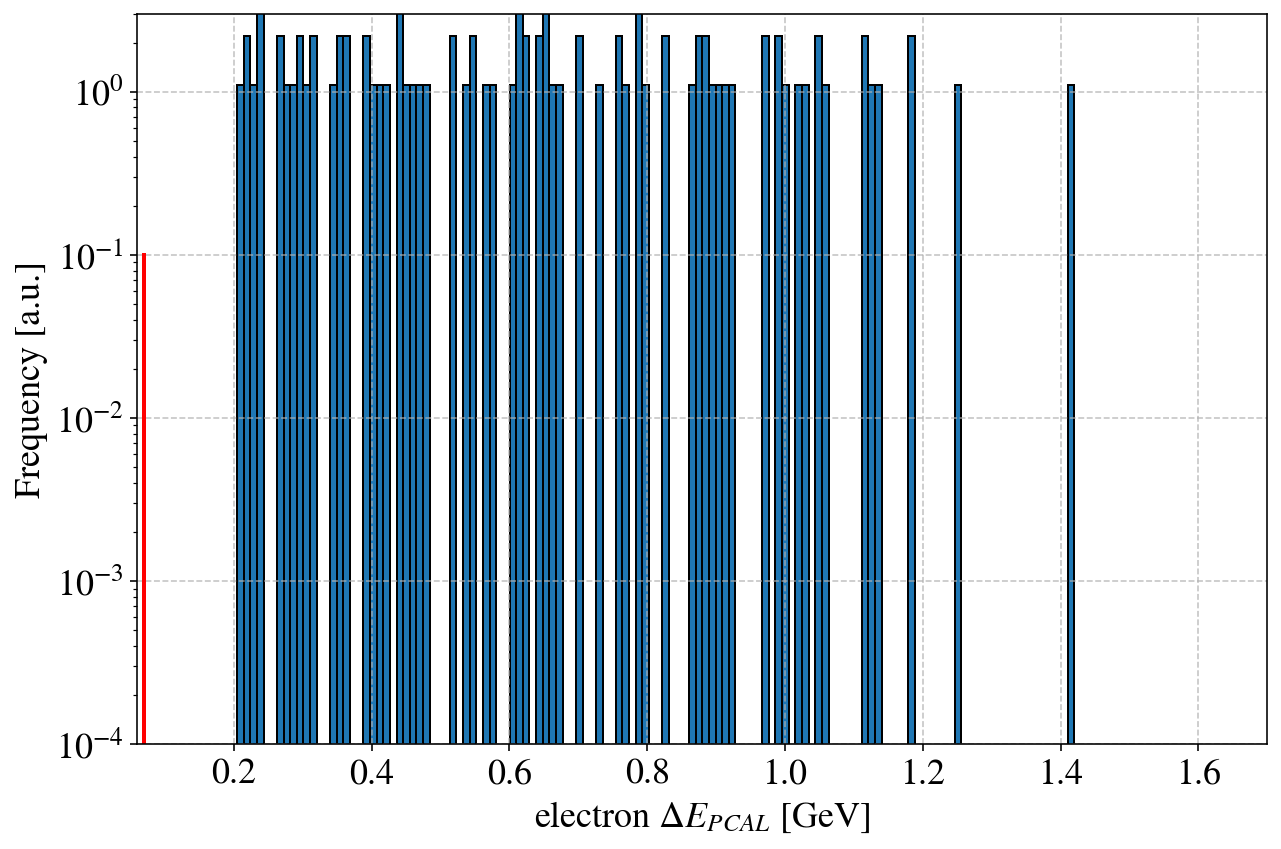

In [9]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.06,1.7,171
x = np.array(e_E_PCAL[pi_ch])

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'electron $\Delta E_{PCAL}$ [GeV]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-0),do_add_grid=True)
ax.set_yscale('log')
plt.plot([e_E_PCALmin,e_E_PCALmin],[1e-7,1e-1],'-r',linewidth=2);

save_figure(filename = figures_path + 'e_E_PCAL' + '.pdf')

In [ ]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.06,1.7,171
x = np.array(e_E_PCAL[pi_ch])

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'electron $\Delta E_{PCAL}$ [GeV]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-0),do_add_grid=True)
ax.set_yscale('log')
plt.plot([e_E_PCALmin,e_E_PCALmin],[1e-7,1e-1],'-r',linewidth=2);

save_figure(filename = figures_path + 'e_E_PCAL_after_cuts' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_ECAL_vs_e_PCAL.pdf


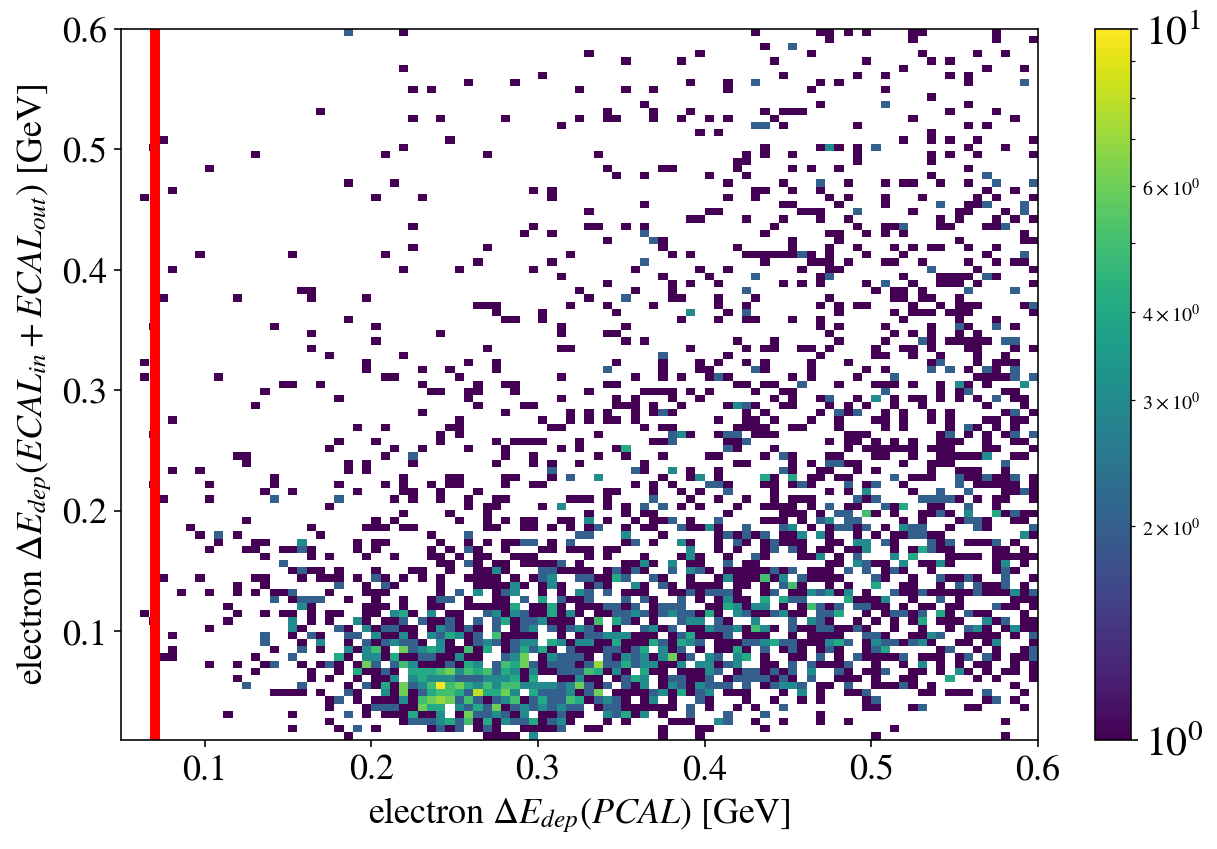

In [17]:
# PCAL vs. ECAL
pi_ch = 'piplus'
xmin,xmax,ymin,ymax,Nbins = 0.05,0.6,0.01,0.6,100
x = np.array(e_E_PCAL[pi_ch])
y = np.array(e_E_ECIN[pi_ch]) + np.array(e_E_ECOUT[pi_ch])
e_E_PCALmin = float(cuts[cuts.parameter=='e_E_PCAL_min'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)), 
           norm=LogNorm() );
set_axes(ax,'electron $\Delta E_{dep} (PCAL)$ [GeV]','electron $\Delta E_{dep} (ECAL_{in} + ECAL_{out})$ [GeV]',fontsize=18)
cbar=plt.colorbar()
cbar.ax.tick_params(axis="both", labelsize=21)
plt.plot([e_E_PCALmin,e_E_PCALmin],ax.get_ylim(),'-r',linewidth=5);

save_figure(filename = figures_path + 'e_ECAL_vs_e_PCAL' + '.pdf')

## (1.2) Add electron momentum and Vertex $z$-position

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/SamplingFraction_vs_e_P.pdf


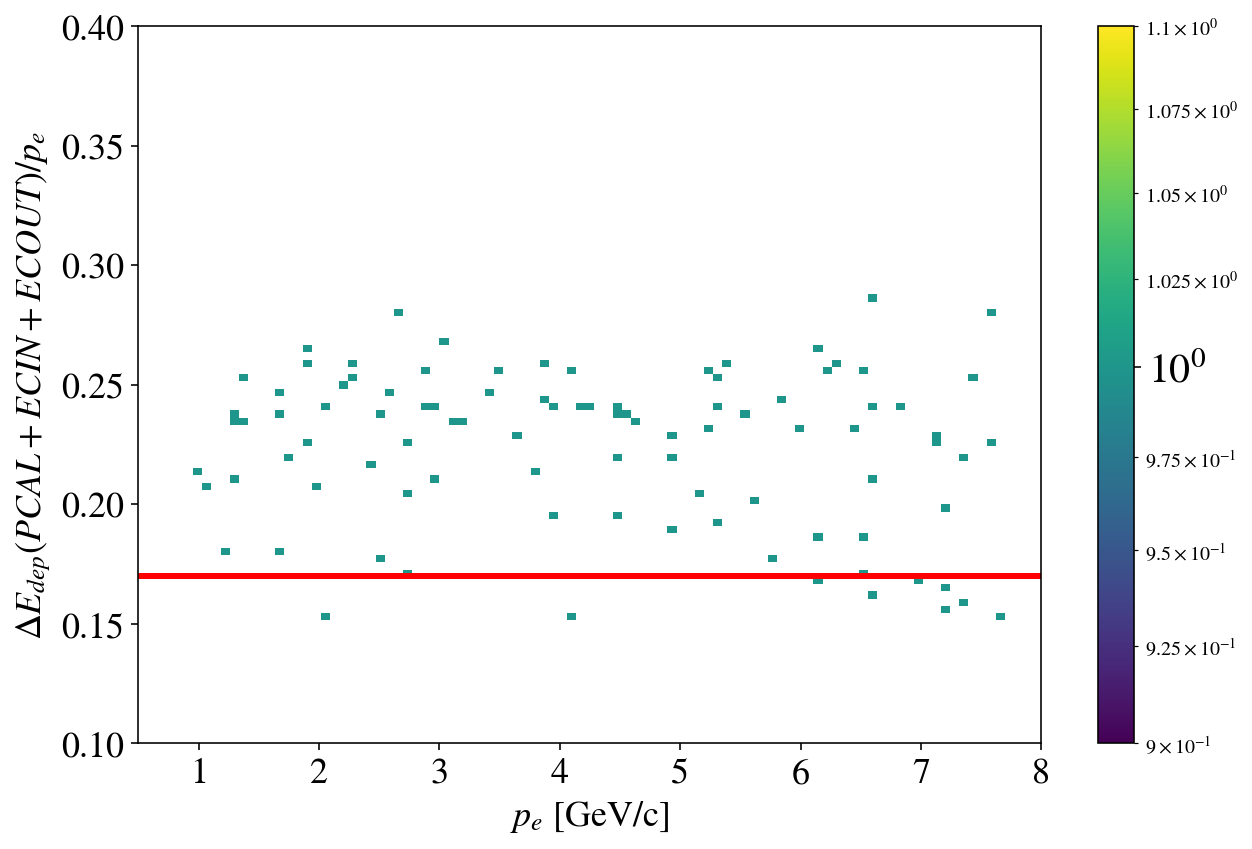

In [11]:
# SamplingFraction vs. e_P
pi_ch = 'piplus'
xmin,xmax,ymin,ymax,Nbins = .5,8,0.1,0.4,100
x = np.array(p_e[pi_ch])
y = (np.array(e_E_PCAL[pi_ch]) + np.array(e_E_ECIN[pi_ch])+ np.array(e_E_ECOUT[pi_ch]))/np.array(p_e[pi_ch])
SamplingFraction_min = float(cuts[cuts.parameter=='SamplingFraction_min'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)), 
           norm=LogNorm() );
set_axes(ax,'$p_e$ [GeV/c]','$\Delta E_{dep}(PCAL + ECIN + ECOUT) / p_e$',fontsize=18)
cbar=plt.colorbar()
cbar.ax.tick_params(axis="both", labelsize=21)
plt.plot([0,10],[SamplingFraction_min,SamplingFraction_min],'-r',linewidth=3);

save_figure(filename = figures_path + 'SamplingFraction_vs_e_P' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_ECIN_vs_e_PCAL.pdf


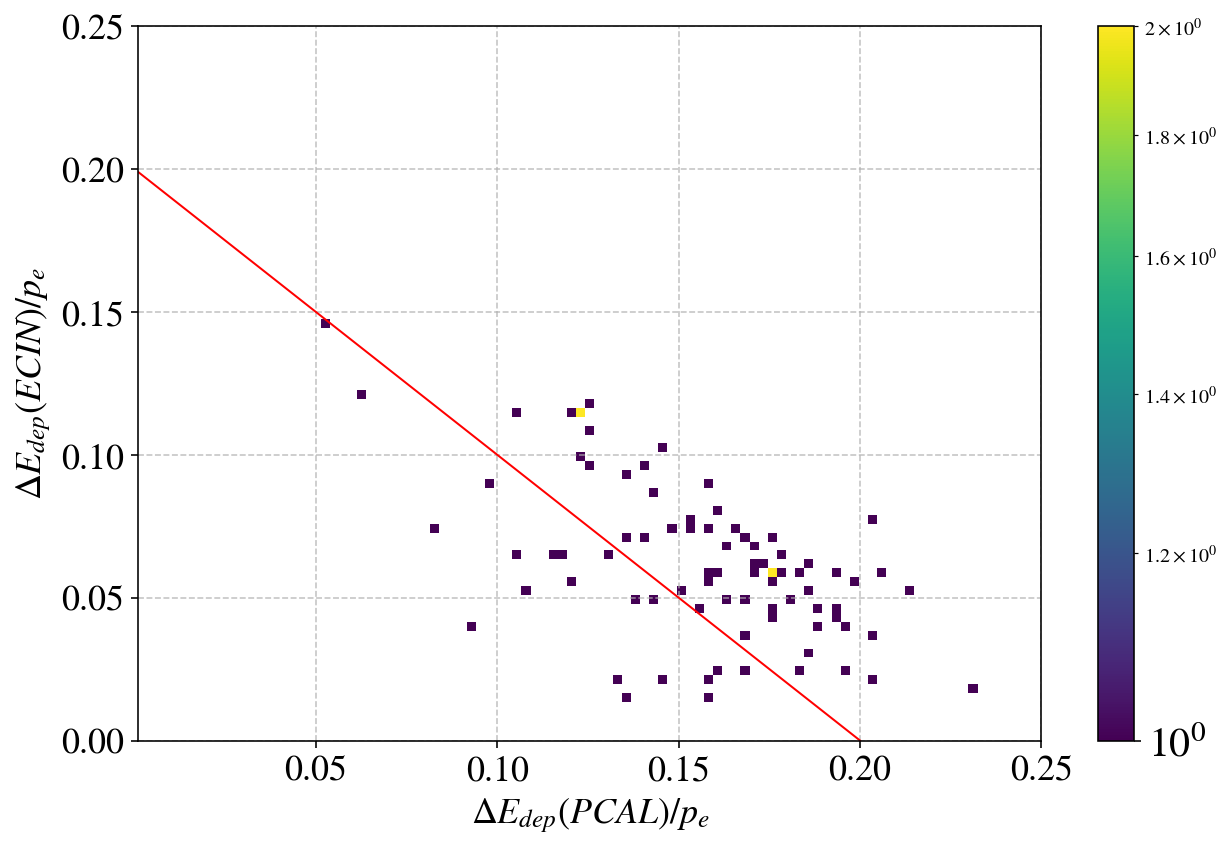

In [12]:
# SamplingFraction vs. e_P
pi_ch = 'piplus'
xmin,xmax,ymin,ymax,Nbins = 0.001,0.25,0.001,0.31,100
x = np.array(e_E_PCAL[pi_ch])/np.array(p_e[pi_ch])
y = np.array(e_E_ECIN[pi_ch])/np.array(p_e[pi_ch])

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)), 
           norm=LogNorm() );
set_axes(ax,'$\Delta E_{dep}(PCAL) / p_e$','$\Delta E_{dep}(ECIN) / p_e$',ylim=(0,0.25),fontsize=18, do_add_grid=True)
cbar=plt.colorbar()
cbar.ax.tick_params(axis="both", labelsize=21)
plt.plot([0,0.2],[0.2,0],'-r',linewidth=1);

save_figure(filename = figures_path + 'e_ECIN_vs_e_PCAL' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Ve_z.pdf


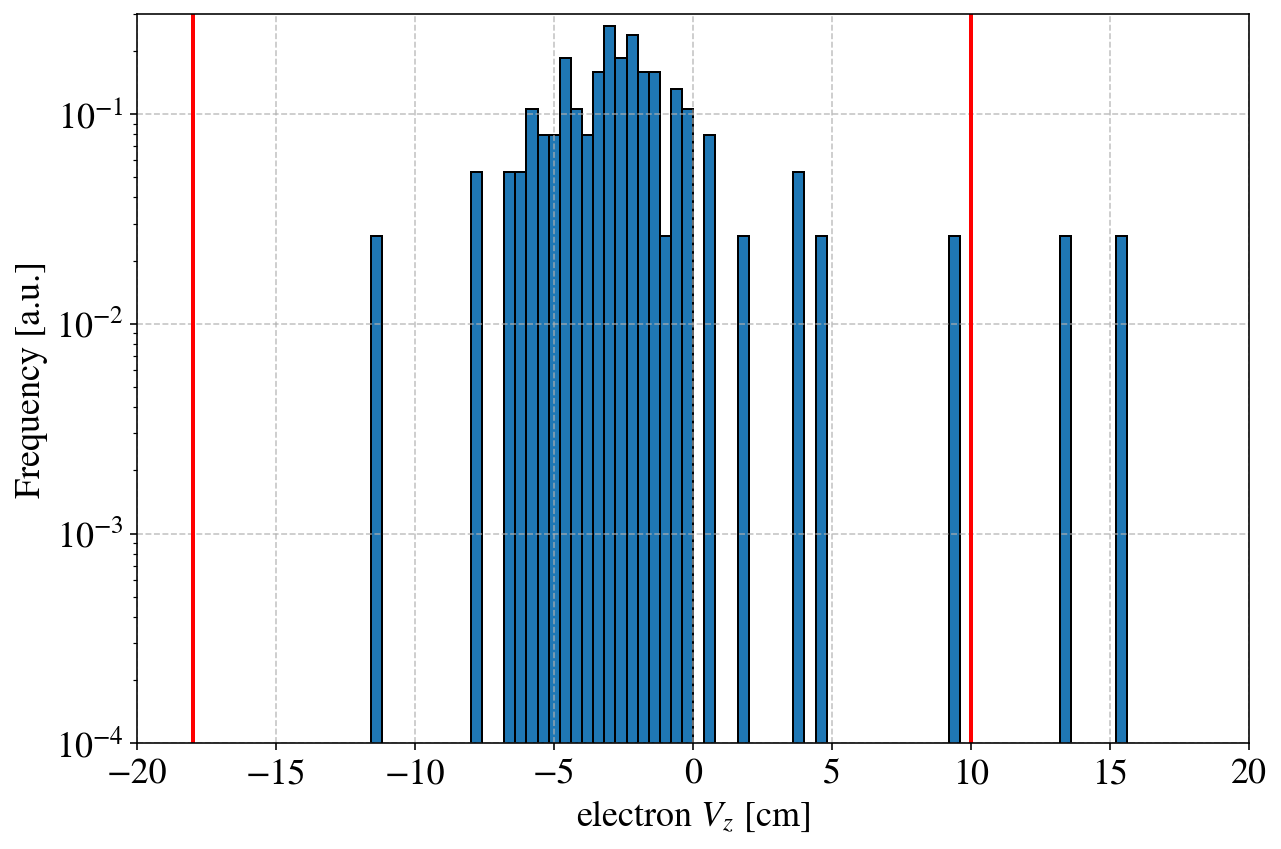

In [13]:
# electron vertex z-position
pi_ch = 'piplus'
xmin,xmax,Nbins = -20,20,101
x = np.array(Ve_z[pi_ch])
x = x[np.abs(x)>0]
Ve_z_min = float(cuts[cuts.parameter=='Vz_e_min_outbending'].value)
Ve_z_max = float(cuts[cuts.parameter=='Vz_e_max_outbending'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'electron $V_z$ [cm]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-1),do_add_grid=True)
ax.set_yscale('log')
plt.plot([Ve_z_min,Ve_z_min],[1e-4,1],'-r',linewidth=2);
plt.plot([Ve_z_max,Ve_z_max],[1e-4,1],'-r',linewidth=2);

save_figure(filename = figures_path + 'Ve_z' + '.pdf')

In [14]:
# Difference between electron and pion vertex z-position
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = -100,100,101


for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(Vpi_z[pi_ch]) - np.array(Ve_z[pi_ch])
    x = x[np.abs(x)>0]
    dVe_z_max = float(cuts[cuts.parameter=='(Ve-Vpi)_z_max'].value)

    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$V^\pi_z - V^e_z$ [cm]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,3e-1),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([dVe_z_max,dVe_z_max],[1e-5,1],'-r',linewidth=2);
    plt.plot([-dVe_z_max,-dVe_z_max],[1e-5,1],'-r',linewidth=2);

save_figure(filename = figures_path + 'Vpi_z_diff_Ve_z' + '.pdf')

ValueError: operands could not be broadcast together with shapes (45,) (100,) 

<Figure size 1152x432 with 0 Axes>

In [ ]:
Nevntries = NeventsMax
pi_P = dict()
pi_chi2PID = dict()
pi = ROOT.TLorentzVector()

for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    
    filename = '~/Desktop/data/BAND/inclusive_no_cuts/skimmed_SIDIS_sidisdvcs_006421_e_%s.root'%pi_ch
    f = ROOT.TFile(filename)
    tree = f.Get("tree")
    
    pi_P[pi_ch] = []
    pi_chi2PID[pi_ch] = []
    for entryNum in range(0,np.min([Nevntries,tree.GetEntries()])):

        tree.GetEntry(entryNum)
        Npi = getattr(tree,"Npi")
        if Npi>0:
            pi_chi2PID_arr = getattr(tree,"pi_chi2PID")
            pi_chi2PID[pi_ch].append(pi_chi2PID_arr[0] )
            pi =  getattr(tree,"pi") 
            pi_P[pi_ch].append(pi[0].P()) 

    f.Close()
print('done')

In [ ]:
def chi2min(p, pi_ch='piplus'):
    if (pi_ch=="piplus"):
        C       = 0.88;
    elif (pi_ch=="piminus") :
        C       = 0.93;        
    return -C*3;
    
def chi2max(p, pi_ch='piplus'):
    if (pi_ch=="piplus"):
        C       = 0.88;
    elif (pi_ch=="piminus") :
        C       = 0.93;
        
    if (p<2.44):        
        return C*3;    
    elif (p<4.6):        
        return C*( 0.00869 + 14.98587*np.exp(-p/1.18236)+1.81751*np.exp(-p/4.86394) ) ;    
    else:
        return C*( -1.14099 + 24.14992*np.exp(-p/1.36554) + 2.66876*np.exp(-p/6.80552) );

In [ ]:
# chi2PID vs p
xmin,xmax,ymin,ymax,Nbins = 0.1,9,-3,3,100
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):

    ax = fig.add_subplot(1,2,pi_idx)
    
    # The event-selection limit
    p_e_fit = np.linspace(0,10,100)
    plt.plot(p_e_fit,[ chi2min(p,pi_ch) for p in p_e_fit],'-r', linewidth=2)
    plt.plot(p_e_fit,[ chi2max(p,pi_ch) for p in p_e_fit],'-r', linewidth=2)


    
    x = np.array(pi_P[pi_ch])
    y = np.array(pi_chi2PID[pi_ch])

    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)),  norm=LogNorm() );
    
    set_axes(ax,'$p_\pi$ [GeV/c]','$\chi^2_{PID}$',title="$"+pi_label+"$",ylim=(ymin,ymax),fontsize=18, do_add_grid=True)
    cbar=plt.colorbar()
    cbar.ax.tick_params(axis="both", labelsize=21)

save_figure(filename = figures_path + 'pi_chi2PID_vs_pi_P' + '.pdf')

# (2) Kinematical cuts

## (2.1) $Q^2, W, y, p_e, p_\pi, \theta_e, \theta_p$

In [ ]:
# W
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.0,4.7,101
x = np.array(W[pi_ch])
Wmin = float(cuts[cuts.parameter=='W_min'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'$W$ [GeV/c$^2$]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-0),do_add_grid=True)
ax.set_yscale('log')
plt.plot([Wmin,Wmin],[1e-7,3],'-r',linewidth=2);
save_figure(filename = figures_path + 'W_no_cuts' + '.pdf')

In [ ]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.75,9.7,101
x = np.array(Q2[pi_ch])
Q2_min = float(cuts[cuts.parameter=='Q2_min'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'$Q^2$ [(GeV/c)$^2$]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-0),do_add_grid=True)
ax.set_yscale('log')

plt.plot([Q2_min,Q2_min],[1e-7,1],'-r',linewidth=2);


save_figure(filename = figures_path + 'Q2_no_cuts' + '.pdf')

In [ ]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.,1.,101
x = np.array(y[pi_ch])
y_max = float(cuts[cuts.parameter=='y_max'].value)

fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'$y$','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-0),do_add_grid=True)
ax.set_yscale('log')

plt.plot([y_max,y_max],[1e-7,1.4e-0],'-r',linewidth=2);


save_figure(filename = figures_path + 'y_no_cuts' + '.pdf')

In [ ]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 5,40.,121
x = np.array(e_Theta[pi_ch])*180./np.pi
e_theta_min = float(cuts[cuts.parameter=='e_theta_min'].value)
e_theta_max = float(cuts[cuts.parameter=='e_theta_max'].value)


fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'$\\theta_e$ [deg.]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,2e-1),do_add_grid=True)
ax.set_yscale('log')
plt.plot([e_theta_min+0.1,e_theta_min+0.1],[1e-7,1e-1],'-r',linewidth=2);
plt.plot([e_theta_max,e_theta_max],[1e-7,1e-1],'-r',linewidth=2);
save_figure(filename = figures_path + 'e_Theta_no_cuts' + '.pdf')

In [ ]:
pi_ch = 'piplus'
xmin,xmax,Nbins = 0.,11.,101
x = np.array(e_P[pi_ch])
e_P_min = float(cuts[cuts.parameter=='Pe_min'].value)
# e_P_max = float(cuts[cuts.parameter=='Pe_max'].value)
fig = plt.figure(figsize=(9,6),tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
set_axes(ax,'$p_e$ [GeV/c]','Frequency [a.u.]',fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,3e-1),do_add_grid=True)
ax.set_yscale('log')
plt.plot([e_P_min,e_P_min],[1e-7,3e-1],'-r',linewidth=2);
# plt.plot([e_P_max,e_P_max],[1e-7,1e-1],'-r',linewidth=2);
save_figure(filename = figures_path + 'e_P_no_cuts' + '.pdf')

In [ ]:
# pi_P
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = 0,11,101
pi_P_min = float(cuts[cuts.parameter=='Ppi_min'].value)
pi_P_max = float(cuts[cuts.parameter=='Ppi_max'].value)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(pi_P[pi_ch])
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$p_\pi$ [GeV/c]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,1.2e0),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([pi_P_min,pi_P_min],[1e-5,1],'-r',linewidth=2);
    plt.plot([pi_P_max,pi_P_max],[1e-5,1],'-r',linewidth=2);

save_figure(filename = figures_path + 'pi_P_no_cuts' + '.pdf')

In [ ]:
# theta_P
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = 0,150,101
pi_theta_min = float(cuts[cuts.parameter=='pi_theta_min'].value)
pi_theta_max = float(cuts[cuts.parameter=='pi_theta_max'].value)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(pi_Theta[pi_ch])*180./np.pi
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$\\theta_\pi$ [deg.]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,4e-2),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([pi_theta_min,pi_theta_min],[1e-5,1],'-r',linewidth=2);
    plt.plot([pi_theta_max,pi_theta_max],[1e-5,1],'-r',linewidth=2);

save_figure(filename = figures_path + 'pi_Theta_no_cuts' + '.pdf')

In [ ]:
## M_x
Nevntries = NeventsMax
M_x = dict()
pi     = ROOT.TLorentzVector()
p_rest = ROOT.TLorentzVector()
q      = ROOT.TLorentzVector()
p_rest.SetXYZM(0, 0, 0, 0.938272);

for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    
    filename = '~/Desktop/data/BAND/inclusive_no_cuts/skimmed_SIDIS_sidisdvcs_006421_e_%s.root'%pi_ch
    f = ROOT.TFile(filename)
    tree = f.Get("tree")
    
    M_x[pi_ch] = []
    
    for entryNum in range(0,np.min([Nevntries,tree.GetEntries()])):
        tree.GetEntry(entryNum)
        q = getattr(tree,"q") 
        Npi = getattr(tree,"Npi")
        if Npi>0:
            pi = getattr(tree,"pi") 
            M_x[pi_ch].append( ( q + p_rest - pi[0] ).Mag() );
    f.Close()
print('done')

In [ ]:
# M_x
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = 0,4,101
M_x_min = 1.7

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(M_x[pi_ch])
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$M_x$ [GeV/c$^2$]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,0.6),do_add_grid=True)
    # ax.set_yscale('log')
    plt.plot([M_x_min,M_x_min],[1e-5,0.6],'-r',linewidth=2);

save_figure(filename = figures_path + 'M_x_no_cuts' + '.pdf')

## add $z$ of the pion

In [ ]:
# z
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = 0,1.1,101
z_min = 0.3

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(Zpi[pi_ch])
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$z$',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,5.5),
             do_add_grid=True)
    # ax.set_yscale('log')
    plt.plot([z_min,z_min],[1e-5,6],'-r',linewidth=2);
save_figure(filename = figures_path + 'z_no_cuts' + '.pdf')

# (3) Reproduce Alex' acceptance matching cut

In [ ]:
# theta_Pi vs. p_Pi
fig = plt.figure(figsize=(16,6),tight_layout=True)
bins = (np.linspace(1.2,5,100),np.linspace(0,40,100))
sector = 1

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])
    
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist2d( p[pi_sector==sector], theta[pi_sector==sector], bins , cmap='hot_r')

    
    
    # plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$p_\pi$ [GeV/c]','$\\theta_\pi$ [deg.]',
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18,do_add_grid=True)

In [ ]:
fig = plt.figure(figsize=(16,32),tight_layout=True)
delta_p   = 0.5
p_min_arr = np.arange(1.25,5,delta_p)
p_max_arr = p_min_arr + delta_p

theta_bins = np.linspace(4,36,41)
sector = 1
Np = 7

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])


    for p_min,p_max,p_idx in zip(p_min_arr,p_max_arr,range(Np)):
        theta_in_bin = theta[ (pi_sector==sector) & (p_min < p) & (p < p_max) ]
        ax = fig.add_subplot( Np, 2, 2*p_idx + pi_idx )
        h,edges = np.histogram( theta_in_bin, theta_bins )
        # h,edges,_ = ax.hist(theta_in_bin, theta_bins, histtype='step')
        x = (edges[1:]+edges[:-1])/2
        plt.plot(x, h)
        set_axes(ax,'$\\theta_{%s}$ [deg.]'%pi_label,'',
                 title="sector %d, $%.2f < p_{%s} < %.2f$ GeV/c"%(sector,p_min,pi_label,p_max))
        
        # find the theta value for X% of the distribution
        theta_prctl = np.percentile( theta_in_bin, 1 )
        plt.plot([theta_prctl,theta_prctl],[0,np.max(h)],'-r')
        if p_idx>=Np: break

